#**EXPLAINABILITY** <br>
In this notebook, our focus was on achieving explainability when classifying tweets into figurative and non-figurative language. For transparency in our models, we delved into the interpretability of decision trees and Support Vector Machines (SVM). We examined the **feature importances** provided by both the decision tree and SVM models.

To gain insights into specific instances, we explored **local explanations** by examining the decision paths in the tree for individual predictions. This provided a finer understanding of how the models were making decisions at a granular level.

Additionally, we went a step further in our pursuit of explainability by attempting to build a TREPAN model. To achieve this, we utilized an **approximation of TREPAN** by constructing a decision tree and training it on the predictions generated by the SVM. This process aimed to shed light on the SVM's decision-making process, treating it as a 'black box' to be explained.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.tree import DecisionTreeClassifier
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

#from google.colab import drive
#drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


## Decision Tree: global and local

In [ ]:
train_csv = "dataset_first_task/traindata_frames_wordvect_syno_nofeatureselection.csv"
df_train = pd.read_csv(train_csv, encoding='utf-8')

test_csv = "dataset_first_task/testdata_frames_wordvect_syno_nofeatureselection.csv"
df_test = pd.read_csv(test_csv, encoding='utf-8')

# tokenization of text in the training set
df_train['text'] = df_train['text'].apply(word_tokenize)

# tag documents for Doc2Vec
tagged_data = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(df_train['text'])]

# train Doc2Vec model
model = Doc2Vec(vector_size=256, window=5, min_count=1, workers=-1, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# encode words in the training set
X_train = df_train['text'].apply(lambda x: model.infer_vector(x))
y_train = df_train['0']

# train a decision tree on Doc2Vec vectors
classifier = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=2, min_samples_split=2)
classifier.fit(list(X_train), y_train)


df_test['text'] = df_test['text'].apply(word_tokenize)
X_test = df_test['text'].apply(lambda x: model.infer_vector(x))
y_test = df_test['0']
y_pred = classifier.predict(list(X_test))

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

feature_importances = classifier.feature_importances_

# indici delle feature più importanti
top_feature_indices = np.argsort(feature_importances)[::-1][:10]

# otteniamo le parole corrispondenti agli indici delle feature più importanti
top_words = [list(model.wv.index_to_key)[i] for i in top_feature_indices]

In [ ]:
print("Top 10 parole più importanti:")
print(top_words)

Top 10 parole più importanti:
['person', 'tonight', 'hard', 'cool', 'think', 'fact', 'since', 'take', 'find', 'rt']


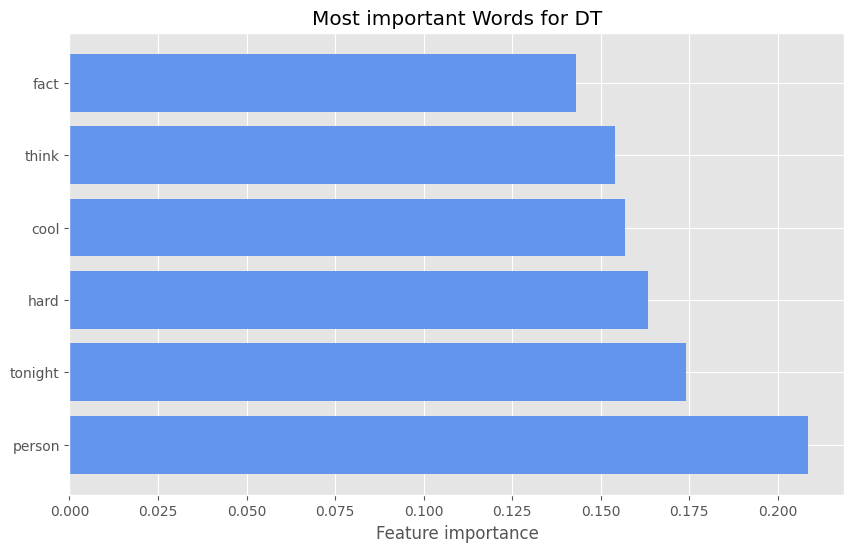

In [ ]:
# soglia per l'importanza delle feature
threshold = 0.075

# solo le feature sopra la soglia
selected_features = [i for i in top_feature_indices if feature_importances[i] > threshold]
selected_words = [list(model.wv.index_to_key)[i] for i in selected_features]

plt.figure(figsize=(10, 6))
plt.style.use('ggplot')
plt.barh(range(len(selected_features)), [feature_importances[i] for i in selected_features], align='center', color='cornflowerblue')
plt.yticks(range(len(selected_features)), selected_words)
plt.xlabel('Feature importance')
plt.title('Most important Words for DT')
plt.savefig('feature_importance.png')
plt.show()


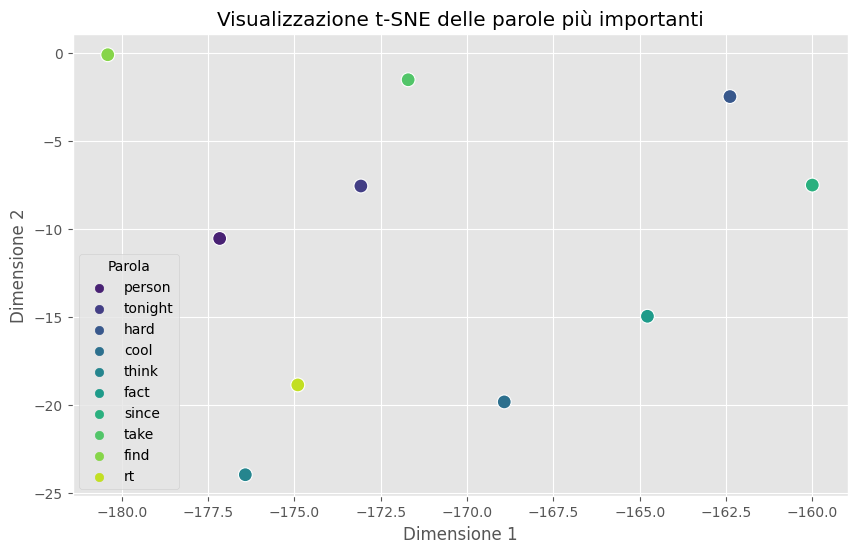

In [ ]:
from sklearn.manifold import TSNE

#visualizzazione tsne delle parole più importanti

tsne = TSNE(n_components=2, perplexity=5, random_state=42)

X_tsne = tsne.fit_transform(model.wv.vectors[top_feature_indices])
df_plot = pd.DataFrame(X_tsne, columns=['Dimensione 1', 'Dimensione 2'])
df_plot['Parola'] = top_words

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Dimensione 1', y='Dimensione 2', data=df_plot, hue='Parola', palette='viridis', s=100)
plt.title('Visualizzazione t-SNE delle parole più importanti')
plt.show()

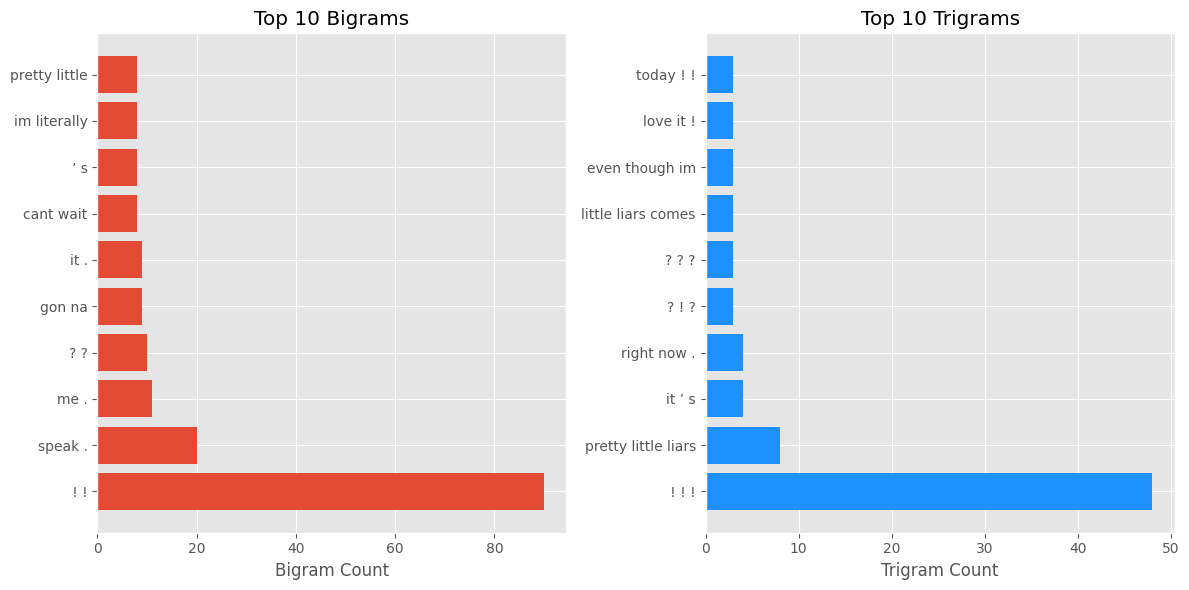

In [ ]:
from nltk import bigrams, trigrams
from collections import Counter

# estrazione dei bigrammi e trigrammi dal testo di training
df_train['bigrams'] = df_train['text'].apply(lambda x: list(bigrams(x)))
df_train['trigrams'] = df_train['text'].apply(lambda x: list(trigrams(x)))

all_bigrams = [item for sublist in df_train['bigrams'] for item in sublist]
all_trigrams = [item for sublist in df_train['trigrams'] for item in sublist]

bigram_counter = Counter(all_bigrams)
trigram_counter = Counter(all_trigrams)

# seleziona i bigrammi e trigrammi più comuni
top_bigrams = bigram_counter.most_common(10)
top_trigrams = trigram_counter.most_common(10)

# estrazione dellle parole dai bigrammi e trigrammi più comuni
top_bigram_words = [' '.join(bigram) for bigram, count in top_bigrams]
top_trigram_words = [' '.join(trigram) for trigram, count in top_trigrams]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(range(len(top_bigrams)), [count for bigram, count in top_bigrams], align='center')
plt.yticks(range(len(top_bigrams)), top_bigram_words)
plt.xlabel('Bigram Count')
plt.title('Top 10 Bigrams')
plt.subplot(1, 2, 2)
plt.barh(range(len(top_trigrams)), [count for trigram, count in top_trigrams], align='center', color='dodgerblue')
plt.yticks(range(len(top_trigrams)), top_trigram_words)
plt.xlabel('Trigram Count')
plt.title('Top 10 Trigrams')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

train_csv = "dataset_first_task/traindata_featureselection.csv"
test_csv = "dataset_first_task/traindata_featureselection.csv"
df_test = pd.read_csv(test_csv, encoding='utf-8')
df_train = pd.read_csv(train_csv, encoding='utf-8')
y_train = df_train['0']
y_test = df_test['0']
df_train = df_train.iloc[:, 1:-1]
df_test = df_test.iloc[:, 1:-1]
df_train.rename(columns={'syn_mean':'synmean', 'Communication_manner':'comm'}, inplace=True)
df_test.rename(columns={'syn_mean':'synmean', 'Communication_manner':'comm'}, inplace=True)
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_leaf=1, min_samples_split=4) #optimal max_depth=8, setting to 3 for interpretability purposes
clf.fit(df_train, y_train)
bin_predictions = clf.predict(df_test)

# creare un file .dot contenente la definizione dell'albero
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=list(df_train.columns),
    class_names=["0", "1"],
    filled=True,
    rounded=True,
    max_depth=3
)

graph = graphviz.Source(dot_data, format="svg")
graph.render("decision_tree")

graph.view("decision_tree")

'decision_tree.svg'

In [ ]:
print('Accuracy %.3f' % accuracy_score(y_test, bin_predictions))

Accuracy 0.624


In [ ]:
#!pip install dtreeviz

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


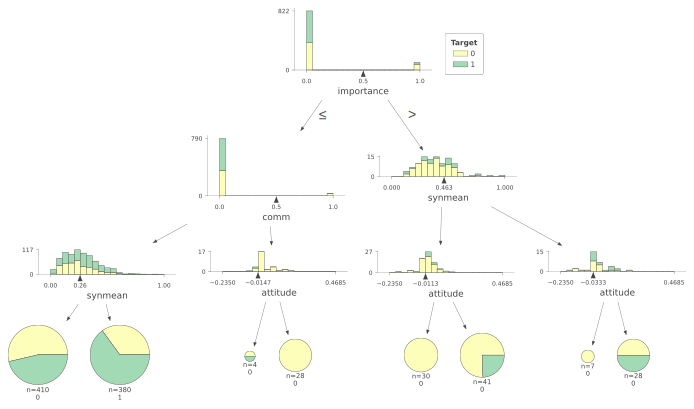

In [ ]:
import dtreeviz
from dtreeviz.trees import *

# avoid "Arial font not found warnings"
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

viz = dtreeviz.model(clf,
               df_train,
               y_train,
               target_name='Target',
               feature_names=list(df_train.columns),
               class_names=["0", "1"]
              )
viz.view()


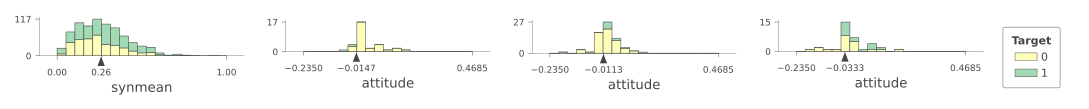

In [ ]:
viz.view(depth_range_to_display=[2,2], scale=1.5)

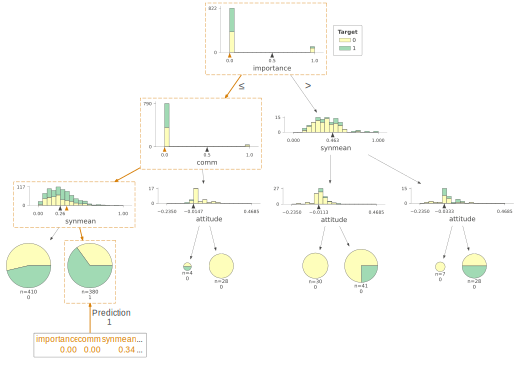

In [ ]:
#LOCAL EXPLAINATIONS
# looking at one instance only (random) - we can see the path followed for the classification
x = df_train.iloc[42]
vis = viz.view(x=x, scale=.75)
#vis.save('expl_local.svg')
vis

In [ ]:
print(viz.explain_prediction_path(x=x))

importance < 0.5
0.26 <= synmean 
comm < 0.5



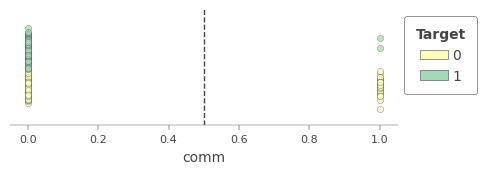

In [ ]:
# Feature space partitioning
viz.ctree_feature_space(features=['comm'], show={'splits','legend'}, figsize=(5,1.5))

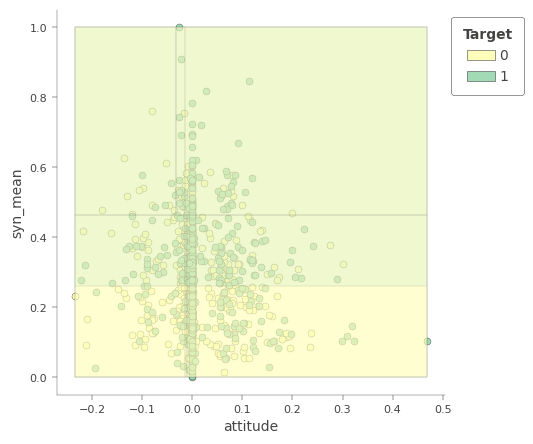

In [ ]:
viz.ctree_feature_space(features=['attitude','syn_mean'],
                               show={'splits','legend'}, figsize=(5,5)) # basically always class 0

## SVM feature importance + decision tree trained on the predictions of a SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

#we train a SVC, bb stands for black box (this is the black box we aim to explain)
bb = SVC(C=10, gamma=0.1, kernel='linear') # best SVM from the previous notebook
bb.fit(df_train, y_train)

SVC(C=10, gamma=0.1, kernel='linear')

top 10 features for importance:
inclusion: 0.042959770114942515
importance: 0.042097701149425265
Communication_manner: 0.027729885057471235
Fairness_evaluation: 0.017744252873563182
dislike: 0.008656609195402277
saddening: 0.008656609195402277
Personal_relationship: 0.007076149425287348
Aggregate: 0.006752873563218383
love: 0.00502873563218389
Make_possible_to_do: 0.004777298850574699


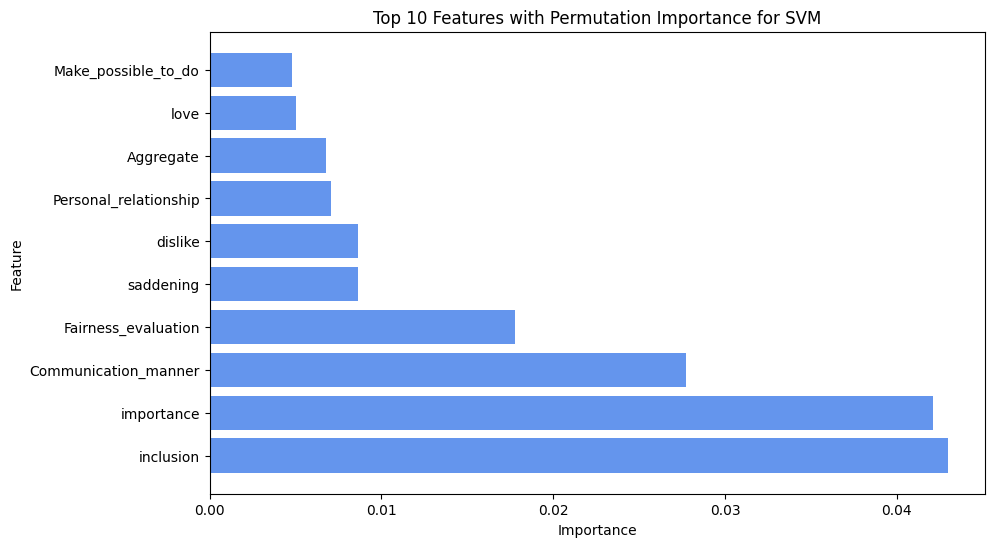

In [ ]:
from sklearn.inspection import permutation_importance

#feature importance of the black box (SVM)
result = permutation_importance(bb, df_test, y_test, n_repeats=30, random_state=42)
feature_importance = result.importances_mean
feature_names = df_train.columns

print("top 10 features for importance:")
for feature, importance in sorted(zip(feature_names, feature_importance), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{feature}: {importance}")

sorted_idx = np.argsort(feature_importance)[::-1]

top_features = sorted_idx[:10]
plt.figure(figsize=(10, 6))
plt.barh(range(10), feature_importance[top_features], color='cornflowerblue')
plt.yticks(range(10), np.array(feature_names)[top_features])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features with Permutation Importance for SVM")
plt.show()


In [ ]:
#we want to explain our SVM using a model which is explainable by design
# just calling the predict or the predict proba of the bb
def bb_predict(X):
    return bb.predict(X)

def bb_predict_proba(X):
    return bb.predict_proba(X)

y_pred = bb_predict(df_test)

print('Accuracy %.3f' % accuracy_score(y_test, y_pred))
print('F1-measure %.3f' % f1_score(y_test, y_pred, average='macro'))

Accuracy 0.655
F1-measure 0.646


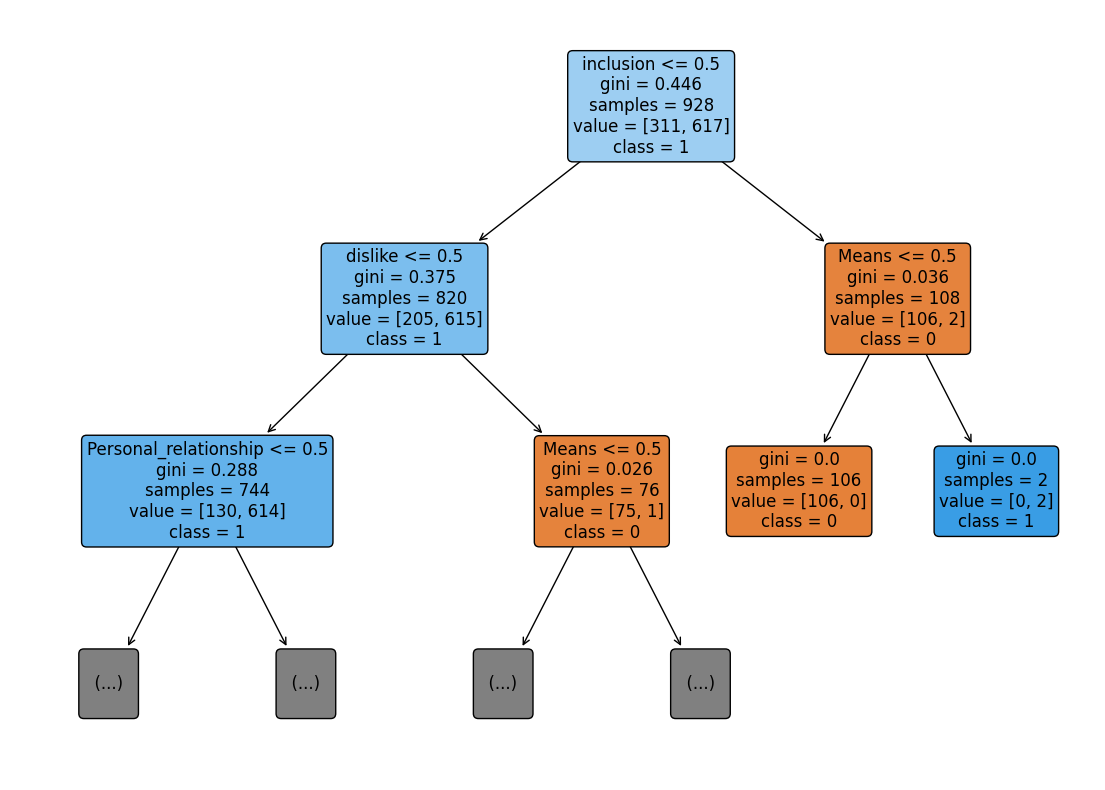

In [ ]:
# we're actually using an approximation for TREPAN (since TreeSurrogate might not be working)
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn import tree

y_pred_train = bb_predict(df_train)  # train!
#our model is trained on the prediction of the black box (our black box is our SVM)

explainer = DecisionTreeClassifier(max_depth=4)  # max_depth = 4 for interpretability - sarà il gloabal explainer della mia bb svm
explainer.fit(df_train, y_pred_train)   # we use as target variable the prediction on the training, NOT the ground truth!

plt.figure(figsize=(14, 10))
plot_tree(explainer,
          feature_names=df_train.columns,
          class_names=['0','1'],
          filled=True,
          rounded=True,
          fontsize=12,
          max_depth=2)
plt.show()